# 🧠🤖 Treinamento de Redes LSTM para Classificação

- **Deadline**: 24/08/2025
- **Entrega**: O trabalho deve ser entregue via sistema Testr.
- **Pontuação**: 50% da nota do T2 (+1 ponto extra).
- O trabalho deve ser realizado individualmente.



## Especificação


### Contexto

O trabalho consiste em realizar o treinamento de redes LSTM usando a base de dados [BBC News Archive disponível no kaggle](https://www.kaggle.com/datasets/hgultekin/bbcnewsarchive?select=bbc-news-data.csv). Esta base de dados contém 2.225 textos publicados no site de notícias da BBC news entre 2004-2005. Cada notícia foi classificada como sendo de um dos seguintes assuntos: business (negócios), entertainment (entretenimento), politics (política), sport (esportes), tech (tecnologia).

O objetivo do trabalho é treinar uma rede neural capaz de identificar o tema de um texto.


### Implementação

- Use o notebook de classificação de sentimentos como ponto de partida.
- use a biblioteca `kagglehub` para fazer o download do dataset no colab.
- Um dos modelos de *word embeddings* disponíveis na biblioteca `gensim` deve ser utilizado para mapear palavras em vetores.
- Use o tipo `nn.LSTM` disponível no `pytorch` (não é necessário implementar a camada LSTM do zero).
- Os dados devem ser divididos em treino, validação e teste. Use o conjunto de validação para ajustar hiperparâmetros e para selecionar o modelo com melhor generalização. Avalie o modelo resultante usando o conjunto de teste apenas ao final.
- Você pode optar por cortar os textos em um tamanho máximo (e.g., 100 palavras), como fizemos no notebook, para que os testes não demorem muito.
- Use o ambiente de `GPU` do colab para evitar que o treinamento demore excessivamente.
- Durante o desenvolvimento, é uma boa idéia usar um subconjunto (e.g., 10%) das notícias para que os testes sejam mais rápidos. Quando tudo estiver correto, faça o treinamento com a base completa.
- Deve ser plotado o gráfico mostrando a evolução da função de perda nos conjuntos de treino e validação.
- Devem ser mostradas as métricas geradas pela função `classification_report` da biblioteca scikit-learn e a matriz de confusão para o conjunto de teste.
- Faça alguns testes qualitativos com textos escritos com você (não use textos da base de dados).
- Discuta brevemente os resultados quantitativos e qualitativos (1-2 parágrafos, no máximo).



### Pontos Extras

Receberá um ponto extra, o aluno que:
- Utilizar um LLM baseado em Transformer pré-treinado (e.g., [BERT](https://medium.com/@davidlfliang/intro-getting-started-with-text-embeddings-using-bert-9f8c3b98dee6)) para mapear as notícias em *embeddings*.
- Utilizar uma rede Multilayer Perceptron para classificar os *embeddings*.
- Comparar a performance desta solução com a LSTM.

⚠️**IMPORTANTE**⚠️
- Não é necessário (nem recomendável considerando o prazo) tentar realizar *fine-tuning* do LLM pré-treinado.
- Estes modelos são SUPER-ULTRA-MASTER-BLASTER lentos na CPU. Use o ambiente de GPU do colab para evitar ficar 20h esperando para transformar os textos em *embeddings*.
- Salve os embeddings depois da geração para evitar ter que gerá-los novamente. Quando necessário, faça upload do arquivo novamente para o colab.

In [1]:
# Instalação de bibliotecas necessárias (executar apenas uma vez)
!pip install -q kagglehub gensim torch torchvision torchaudio scikit-learn nltk
!pip install -U gensim # Problema com a biblioteca gensim para instalacao...

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from gensim.models import KeyedVectors
from gensim import downloader as api
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

import re
import string

import os
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Preparação do Dataset

In [3]:
# use a biblioteca kagglehub para fazer o download do dataset no colab.
import kagglehub

dataset_path = kagglehub.dataset_download("hgultekin/bbcnewsarchive")

csv_path = None
for root, dirs, files in os.walk(dataset_path):
    for fname in files:
        if fname.endswith('.csv'):
            csv_path = os.path.join(root, fname)
            break
    if csv_path:
        break

assert csv_path is not None, "Arquivo CSV não encontrado no dataset"

bbc_df = pd.read_csv(csv_path, sep='\t')
bbc_df.head()

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


In [4]:
# Testing
bbc_df = bbc_df.sample(frac=1/4, random_state=42)

In [5]:
# Carrega embeddings pré-treinados do Gensim.
# Um dos modelos de word embeddings disponíveis na biblioteca gensim deve ser utilizado para mapear palavras em vetores.
embedding_model = api.load('glove-wiki-gigaword-100')

In [6]:
# Verificar a distribuição de categorias no dataset
bbc_df['category'].value_counts()

,count
category,
business,142
sport,122
tech,104
politics,95
entertainment,93


In [7]:
# Função para pré-processar o texto
def preprocess_text(text):
    # Converter para minúsculas
    text = text.lower()

    # Remover pontuação
    text = re.sub(f'[{string.punctuation}]', ' ', text)

    # Remover números
    text = re.sub(r'\d+', '', text)

    # Remover espaços extras
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenizar
    words = text.split()

    # Remover stopwords
    words = [word for word in words if word not in stop_words]

    return words

# Aplicar a função de pré-processamento ao conteúdo e título
bbc_df['processed_content'] = bbc_df['content'].progress_apply(preprocess_text)
print("Pré-processamento concluído!")

  0%|          | 0/556 [00:00<?, ?it/s]

Pré-processamento concluído!


In [8]:
# Codificar as categorias usando LabelEncoder
label_encoder = LabelEncoder()
bbc_df['category_encoded'] = label_encoder.fit_transform(bbc_df['category'])

# Verificar o mapeamento das categorias
category_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Mapeamento das categorias:")
for category, code in category_mapping.items():
    print(f"{category}: {code}")

# Definir o tamanho máximo de sequência (palavras por texto)
max_seq_length = 100

# Dividir os dados em treino (70%), validação (10%) e teste (20%)
train_df, temp_df = train_test_split(bbc_df, test_size=0.3, random_state=42, stratify=bbc_df['category'])
val_df, test_df = train_test_split(temp_df, test_size=2/3, random_state=42, stratify=temp_df['category'])

print(f"Tamanho do conjunto de treino: {len(train_df)}")
print(f"Tamanho do conjunto de validação: {len(val_df)}")
print(f"Tamanho do conjunto de teste: {len(test_df)}")

Mapeamento das categorias:
business: 0
entertainment: 1
politics: 2
sport: 3
tech: 4
Tamanho do conjunto de treino: 389
Tamanho do conjunto de validação: 55
Tamanho do conjunto de teste: 112


In [9]:
# Criar uma classe de dataset personalizada para os textos
class NewsDataset(Dataset):
    def __init__(self, dataframe, embedding_model, max_seq_length):
        self.data = dataframe
        self.embedding_model = embedding_model
        self.max_seq_length = max_seq_length
        self.embedding_dim = embedding_model.vector_size

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['processed_content']
        label = self.data.iloc[idx]['category_encoded']

        # Limitar o tamanho do texto ao máximo definido
        text = text[:self.max_seq_length]

        # Converter palavras para embeddings
        embeddings = []
        for word in text:
            if word in self.embedding_model:
                embeddings.append(torch.tensor(self.embedding_model[word], dtype=torch.float))
            else:
                # Vetor de zeros para palavras desconhecidas
                embeddings.append(torch.zeros(self.embedding_dim))

        # Se não houver palavras válidas, criar um tensor de zeros
        if not embeddings:
            embeddings = [torch.zeros(self.embedding_dim)]

        # Converter para tensor
        embeddings = torch.stack(embeddings)

        return {
            'embeddings': embeddings,
            'label': torch.tensor(label, dtype=torch.long),
            'length': torch.tensor(len(embeddings), dtype=torch.long)
        }

# Função para padding na criação de batches
def collate_fn(batch):
    # Extrair embeddings e labels
    embeddings = [item['embeddings'] for item in batch]
    labels = torch.stack([item['label'] for item in batch])
    lengths = torch.stack([item['length'] for item in batch])

    # Aplicar padding
    embeddings_padded = pad_sequence(embeddings, batch_first=True)

    return {
        'embeddings': embeddings_padded,
        'label': labels,
        'length': lengths
    }

In [10]:
# Criar datasets
train_dataset = NewsDataset(train_df, embedding_model, max_seq_length)
val_dataset = NewsDataset(val_df, embedding_model, max_seq_length)
test_dataset = NewsDataset(test_df, embedding_model, max_seq_length)

# Definir tamanho de batch
batch_size = 32

# Criar dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

# Verificar se temos GPU disponível
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo utilizado: {device}")

Dispositivo utilizado: cuda


In [11]:
# Definir o modelo LSTM
class LSTMClassifierAula(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, dropout):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=embedding_dim,     # embedding size
            hidden_size=hidden_dim,
            bidirectional=False,
            batch_first=True,
        )

        self.dropout = nn.Dropout(p=0.5)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, sequence):
        _, (hidden, cell) = self.lstm(sequence)
        # hidden tem shape [seq_length=1, batch_size, hidden_size].
        # O squeeze abaixo remove a primeira dimensão de forma que
        # o shape se torna [batch_size, hidden_size].
        dropped = self.dropout(hidden.squeeze(0))
        prediction = self.fc(dropped)

        return prediction

hidden_dim = 128
dropout = 0.5
embedding_dim = embedding_model.vector_size
output_dim = len(label_encoder.classes_)

model = LSTMClassifierAula(
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    dropout=dropout
)

model = model.to(device)
print(model)

LSTMClassifierAula(
  (lstm): LSTM(100, 128, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)


In [12]:
# Definir critério de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Função para calcular a acurácia
def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(preds == labels).item() / len(labels)

# Função para treinar o modelo
def train(model, iterator, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    epoch_acc = 0

    for batch in tqdm(iterator, desc="Treinando"):
        # Obter dados do batch
        embeddings = batch['embeddings'].to(device)
        labels = batch['label'].to(device)

        # Zerar gradientes
        optimizer.zero_grad()

        # Forward pass
        outputs = model(embeddings)

        # Calcular perda
        loss = criterion(outputs, labels)

        # Backward pass e otimização
        loss.backward()
        optimizer.step()

        # Calcular acurácia
        acc = calculate_accuracy(outputs, labels)

        # Acumular estatísticas
        epoch_loss += loss.item()
        epoch_acc += acc

    # Retornar médias
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# Função para avaliar o modelo
def evaluate(model, iterator, criterion, device):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad():
        for batch in tqdm(iterator, desc="Avaliando"):
            # Obter dados do batch
            embeddings = batch['embeddings'].to(device)
            labels = batch['label'].to(device)

            # Forward pass
            outputs = model(embeddings)

            # Calcular perda
            loss = criterion(outputs, labels)

            # Calcular acurácia
            acc = calculate_accuracy(outputs, labels)

            # Acumular estatísticas
            epoch_loss += loss.item()
            epoch_acc += acc

    # Retornar médias
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [13]:
# Número de épocas para treinamento
n_epochs = 100

# Listas para armazenar histórico de perda e acurácia
train_losses = []
val_losses = []
train_accs = []
val_accs = []

best_val_loss = float('inf')

# Treinamento do modelo
for epoch in range(n_epochs):
    print(f"\nÉpoca {epoch+1}/{n_epochs}")

    # Treinar o modelo
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)

    # Avaliar o modelo
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    # Armazenar resultados para plotagem
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # Imprimir resultados
    print(f"Treino - Perda: {train_loss:.4f}, Acurácia: {train_acc:.4f}")
    print(f"Validação - Perda: {val_loss:.4f}, Acurácia: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # Salvar o melhor modelo
        torch.save(model.state_dict(), 'best_model.pt')

# Carregar o melhor modelo
model.load_state_dict(torch.load('best_model.pt'))


Época 1/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 1.5709, Acurácia: 0.2928
Validação - Perda: 1.5151, Acurácia: 0.3927

Época 2/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 1.4130, Acurácia: 0.4404
Validação - Perda: 1.2830, Acurácia: 0.4457

Época 3/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 1.0330, Acurácia: 0.6601
Validação - Perda: 0.9240, Acurácia: 0.6950

Época 4/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.6289, Acurácia: 0.8115
Validação - Perda: 0.6771, Acurácia: 0.8288

Época 5/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.7331, Acurácia: 0.8115
Validação - Perda: 0.7981, Acurácia: 0.7880

Época 6/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.4743, Acurácia: 0.8726
Validação - Perda: 0.5057, Acurácia: 0.8567

Época 7/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.5735, Acurácia: 0.8524
Validação - Perda: 0.9140, Acurácia: 0.6855

Época 8/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.6066, Acurácia: 0.8173
Validação - Perda: 0.7983, Acurácia: 0.7507

Época 9/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.7550, Acurácia: 0.7837
Validação - Perda: 0.8054, Acurácia: 0.7697

Época 10/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.6893, Acurácia: 0.7933
Validação - Perda: 0.6998, Acurácia: 0.7480

Época 11/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.5026, Acurácia: 0.8500
Validação - Perda: 0.7666, Acurácia: 0.7480

Época 12/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.4794, Acurácia: 0.8803
Validação - Perda: 0.7157, Acurácia: 0.7914

Época 13/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.5263, Acurácia: 0.8490
Validação - Perda: 0.7740, Acurácia: 0.7853

Época 14/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.4687, Acurácia: 0.8798
Validação - Perda: 0.6775, Acurácia: 0.8071

Época 15/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.4749, Acurácia: 0.8822
Validação - Perda: 0.7833, Acurácia: 0.7819

Época 16/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.6435, Acurácia: 0.8019
Validação - Perda: 1.0896, Acurácia: 0.6576

Época 17/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.8608, Acurácia: 0.7563
Validação - Perda: 0.8286, Acurácia: 0.7045

Época 18/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.6508, Acurácia: 0.7812
Validação - Perda: 0.6947, Acurácia: 0.7697

Época 19/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.5563, Acurácia: 0.8010
Validação - Perda: 0.5555, Acurácia: 0.8227

Época 20/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.4079, Acurácia: 0.8918
Validação - Perda: 0.4574, Acurácia: 0.8879

Época 21/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.3899, Acurácia: 0.8918
Validação - Perda: 0.5638, Acurácia: 0.8071

Época 22/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.3047, Acurácia: 0.9231
Validação - Perda: 0.4653, Acurácia: 0.8505

Época 23/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.2746, Acurácia: 0.9231
Validação - Perda: 0.3479, Acurácia: 0.9035

Época 24/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.2813, Acurácia: 0.9197
Validação - Perda: 0.6400, Acurácia: 0.8098

Época 25/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.7950, Acurácia: 0.7755
Validação - Perda: 1.2543, Acurácia: 0.6603

Época 26/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 1.1968, Acurácia: 0.6880
Validação - Perda: 1.1390, Acurácia: 0.6603

Época 27/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 1.2680, Acurácia: 0.6264
Validação - Perda: 1.2208, Acurácia: 0.5951

Época 28/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 1.0160, Acurácia: 0.6293
Validação - Perda: 1.0417, Acurácia: 0.5734

Época 29/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.7945, Acurácia: 0.7298
Validação - Perda: 0.8170, Acurácia: 0.7167

Época 30/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.9054, Acurácia: 0.7212
Validação - Perda: 1.2121, Acurácia: 0.5700

Época 31/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 1.1398, Acurácia: 0.5774
Validação - Perda: 1.1457, Acurácia: 0.5014

Época 32/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 1.0255, Acurácia: 0.5904
Validação - Perda: 1.0752, Acurácia: 0.5265

Época 33/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.9866, Acurácia: 0.6288
Validação - Perda: 0.9828, Acurácia: 0.6325

Época 34/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.8976, Acurácia: 0.6880
Validação - Perda: 0.8826, Acurácia: 0.6916

Época 35/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.7071, Acurácia: 0.7740
Validação - Perda: 0.7014, Acurácia: 0.7880

Época 36/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.5605, Acurácia: 0.8548
Validação - Perda: 0.6341, Acurácia: 0.8288

Época 37/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.5328, Acurácia: 0.8774
Validação - Perda: 0.6202, Acurácia: 0.8071

Época 38/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.4521, Acurácia: 0.8692
Validação - Perda: 0.5671, Acurácia: 0.8601

Época 39/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.4363, Acurácia: 0.8837
Validação - Perda: 0.5446, Acurácia: 0.7914

Época 40/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.4296, Acurácia: 0.9077
Validação - Perda: 0.4789, Acurácia: 0.8601

Época 41/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.3277, Acurácia: 0.9279
Validação - Perda: 0.5697, Acurácia: 0.8444

Época 42/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.2845, Acurácia: 0.9399
Validação - Perda: 0.6273, Acurácia: 0.7914

Época 43/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.3490, Acurácia: 0.9279
Validação - Perda: 0.6964, Acurácia: 0.8166

Época 44/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.5254, Acurácia: 0.8438
Validação - Perda: 0.5225, Acurácia: 0.8349

Época 45/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.5019, Acurácia: 0.8731
Validação - Perda: 1.3126, Acurácia: 0.6264

Época 46/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 1.0711, Acurácia: 0.6952
Validação - Perda: 1.3125, Acurácia: 0.5700

Época 47/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 1.0010, Acurácia: 0.6591
Validação - Perda: 0.8387, Acurácia: 0.7323

Época 48/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.5650, Acurácia: 0.8043
Validação - Perda: 0.9293, Acurácia: 0.6950

Época 49/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.5148, Acurácia: 0.8438
Validação - Perda: 0.8096, Acurácia: 0.7697

Época 50/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.4765, Acurácia: 0.8216
Validação - Perda: 0.8649, Acurácia: 0.7323

Época 51/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.4944, Acurácia: 0.8452
Validação - Perda: 0.7398, Acurácia: 0.7697

Época 52/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.3911, Acurácia: 0.9038
Validação - Perda: 0.6630, Acurácia: 0.7697

Época 53/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.3727, Acurácia: 0.8990
Validação - Perda: 0.6874, Acurácia: 0.8010

Época 54/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.3284, Acurácia: 0.9111
Validação - Perda: 0.6212, Acurácia: 0.8227

Época 55/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.3181, Acurácia: 0.8894
Validação - Perda: 0.5978, Acurácia: 0.8288

Época 56/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.3441, Acurácia: 0.8933
Validação - Perda: 0.6296, Acurácia: 0.8010

Época 57/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.3222, Acurácia: 0.9111
Validação - Perda: 0.6105, Acurácia: 0.8071

Época 58/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.3416, Acurácia: 0.9101
Validação - Perda: 0.7776, Acurácia: 0.8071

Época 59/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.2802, Acurácia: 0.9173
Validação - Perda: 0.5926, Acurácia: 0.8227

Época 60/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.5125, Acurácia: 0.8572
Validação - Perda: 1.4207, Acurácia: 0.6359

Época 61/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 1.1889, Acurácia: 0.6938
Validação - Perda: 1.1247, Acurácia: 0.6420

Época 62/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.7082, Acurácia: 0.7442
Validação - Perda: 0.8116, Acurácia: 0.6855

Época 63/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.6134, Acurácia: 0.7524
Validação - Perda: 0.6904, Acurácia: 0.6916

Época 64/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.5417, Acurácia: 0.8077
Validação - Perda: 0.6471, Acurácia: 0.7106

Época 65/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.5042, Acurácia: 0.8043
Validação - Perda: 0.6335, Acurácia: 0.7106

Época 66/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.4426, Acurácia: 0.8413
Validação - Perda: 0.6374, Acurácia: 0.7541

Época 67/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.4401, Acurácia: 0.8418
Validação - Perda: 0.6227, Acurácia: 0.7697

Época 68/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.3332, Acurácia: 0.9087
Validação - Perda: 0.5595, Acurácia: 0.7914

Época 69/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.3438, Acurácia: 0.8966
Validação - Perda: 0.4763, Acurácia: 0.7976

Época 70/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.3408, Acurácia: 0.8750
Validação - Perda: 0.4512, Acurácia: 0.8132

Época 71/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.3518, Acurácia: 0.8827
Validação - Perda: 0.4599, Acurácia: 0.8349

Época 72/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.2863, Acurácia: 0.9014
Validação - Perda: 0.4381, Acurácia: 0.8784

Época 73/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.2735, Acurácia: 0.9173
Validação - Perda: 0.4466, Acurácia: 0.8723

Época 74/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.2347, Acurácia: 0.9255
Validação - Perda: 0.4012, Acurácia: 0.8567

Época 75/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.2425, Acurácia: 0.9255
Validação - Perda: 0.3872, Acurácia: 0.8784

Época 76/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.2458, Acurácia: 0.9293
Validação - Perda: 0.4444, Acurácia: 0.8349

Época 77/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.1766, Acurácia: 0.9471
Validação - Perda: 0.3293, Acurácia: 0.9158

Época 78/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.1901, Acurácia: 0.9399
Validação - Perda: 0.3847, Acurácia: 0.8723

Época 79/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.1843, Acurácia: 0.9519
Validação - Perda: 0.3862, Acurácia: 0.8940

Época 80/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.1986, Acurácia: 0.9543
Validação - Perda: 0.4322, Acurácia: 0.8940

Época 81/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.1856, Acurácia: 0.9495
Validação - Perda: 0.3840, Acurácia: 0.8784

Época 82/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.2193, Acurácia: 0.9399
Validação - Perda: 0.3924, Acurácia: 0.8601

Época 83/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.1914, Acurácia: 0.9495
Validação - Perda: 0.3090, Acurácia: 0.9096

Época 84/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 1.2291, Acurácia: 0.6500
Validação - Perda: 1.0472, Acurácia: 0.6012

Época 85/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 1.2383, Acurácia: 0.5139
Validação - Perda: 1.3670, Acurácia: 0.4708

Época 86/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 1.0772, Acurácia: 0.5760
Validação - Perda: 1.0884, Acurácia: 0.5455

Época 87/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.8821, Acurácia: 0.6514
Validação - Perda: 0.9708, Acurácia: 0.7011

Época 88/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.8368, Acurácia: 0.6567
Validação - Perda: 0.7640, Acurácia: 0.7914

Época 89/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.6780, Acurácia: 0.7216
Validação - Perda: 0.7024, Acurácia: 0.7697

Época 90/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.7196, Acurácia: 0.7279
Validação - Perda: 0.7887, Acurácia: 0.7323

Época 91/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.7028, Acurácia: 0.7409
Validação - Perda: 0.6493, Acurácia: 0.8132

Época 92/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.4913, Acurácia: 0.8212
Validação - Perda: 0.5880, Acurácia: 0.7914

Época 93/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.4251, Acurácia: 0.8630
Validação - Perda: 0.5129, Acurácia: 0.7914

Época 94/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.3780, Acurácia: 0.8846
Validação - Perda: 0.4671, Acurácia: 0.8071

Época 95/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.4891, Acurácia: 0.8466
Validação - Perda: 0.5190, Acurácia: 0.8227

Época 96/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.5033, Acurácia: 0.8562
Validação - Perda: 0.4616, Acurácia: 0.8601

Época 97/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.3637, Acurácia: 0.8981
Validação - Perda: 0.4549, Acurácia: 0.8974

Época 98/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.2685, Acurácia: 0.9255
Validação - Perda: 0.5306, Acurácia: 0.8288

Época 99/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.2409, Acurácia: 0.9351
Validação - Perda: 0.4657, Acurácia: 0.8723

Época 100/100


Treinando:   0%|          | 0/13 [00:00<?, ?it/s]

Avaliando:   0%|          | 0/2 [00:00<?, ?it/s]

Treino - Perda: 0.3238, Acurácia: 0.9341
Validação - Perda: 0.6540, Acurácia: 0.8349


<All keys matched successfully>

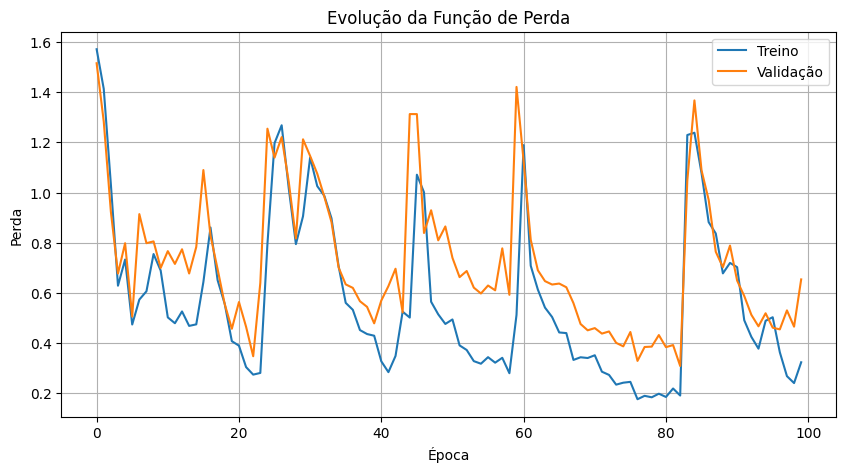

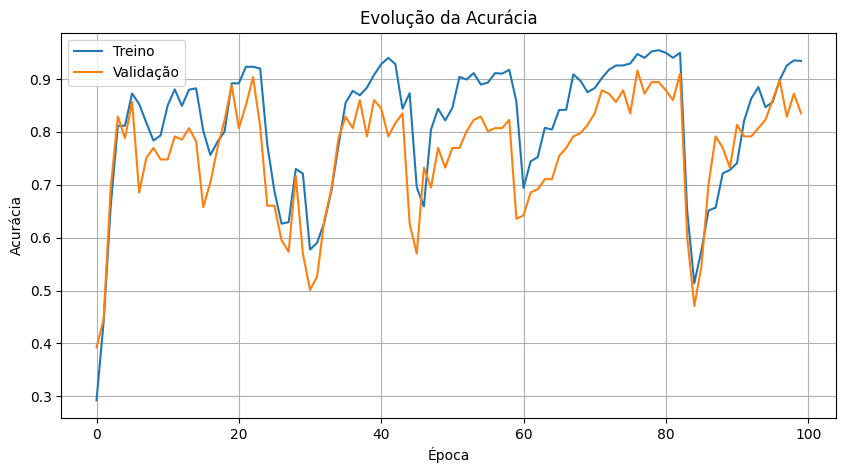

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Plotar gráfico de perda
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Treino')
plt.plot(val_losses, label='Validação')
plt.title('Evolução da Função de Perda')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()
plt.grid(True)
plt.show()

# Plotar gráfico de acurácia
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Treino')
plt.plot(val_accs, label='Validação')
plt.title('Evolução da Acurácia')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)
plt.show()

Avaliando:   0%|          | 0/4 [00:00<?, ?it/s]

Teste - Perda: 0.4998, Acurácia: 0.8750

Relatório de Classificação:
               precision    recall  f1-score   support

     business     0.9524    0.6897    0.8000        29
entertainment     0.9474    0.9474    0.9474        19
     politics     0.6522    0.8333    0.7317        18
        sport     0.8929    1.0000    0.9434        25
         tech     0.9048    0.9048    0.9048        21

     accuracy                         0.8661       112
    macro avg     0.8699    0.8750    0.8654       112
 weighted avg     0.8811    0.8661    0.8657       112



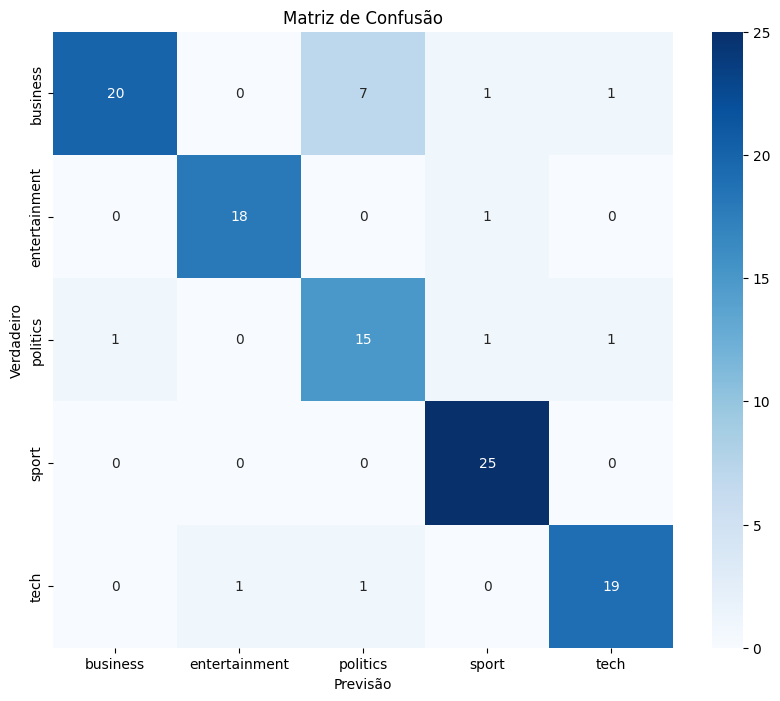

In [15]:
# Avaliação no conjunto de teste
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Teste - Perda: {test_loss:.4f}, Acurácia: {test_acc:.4f}")

# Coletar todas as previsões e labels para o conjunto de teste
y_pred = []
y_true = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        embeddings = batch['embeddings'].to(device)
        labels = batch['label'].to(device)

        outputs = model(embeddings)
        _, predictions = torch.max(outputs, 1)

        y_pred.extend(predictions.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Gerar relatório de classificação
class_names = label_encoder.classes_
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print("\nRelatório de Classificação:")
print(report)

# Matriz de confusão
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Previsão')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

In [16]:
# Função para prever a categoria de um texto
def predict_category(text, model, embedding_model, max_seq_length):
    # Pré-processar o texto
    processed_text = preprocess_text(text)
    processed_text = processed_text[:max_seq_length]

    # Converter palavras para embeddings
    embeddings = []
    for word in processed_text:
        if word in embedding_model:
            embeddings.append(torch.tensor(embedding_model[word], dtype=torch.float))
        else:
            # Vetor de zeros para palavras desconhecidas
            embeddings.append(torch.zeros(embedding_model.vector_size))

    # Se não houver palavras válidas, criar um tensor de zeros
    if not embeddings:
        embeddings = [torch.zeros(embedding_model.vector_size)]

    # Converter para tensor
    embeddings = torch.stack(embeddings).unsqueeze(0).to(device)  # Adicionar dimensão de batch

    # Obter previsão
    model.eval()
    with torch.no_grad():
        output = model(embeddings)
        _, pred = torch.max(output, 1)

    # Converter índice para categoria
    predicted_category = label_encoder.inverse_transform([pred.item()])[0]

    return predicted_category

# Textos para teste qualitativo
test_texts = [
    "The new iPhone was announced today with revolutionary camera technology and improved battery life. The tech community is buzzing with excitement about the latest features.",
    "Manchester United scored a last-minute goal to win the match against Liverpool. The fans went wild as the striker celebrated his winning goal.",
    "The stock market crashed today due to fears of inflation. Many investors lost millions as major companies saw their stock prices plummet.",
    "The new comedy film starring Jennifer Lawrence has broken box office records. Critics praise the hilarious screenplay and stellar performances.",
    "The Prime Minister announced new policies to combat climate change. The opposition party has criticized the plan, saying it doesn't go far enough."
]

# Prever categorias para cada texto
print("\nTestes Qualitativos:")
for i, text in enumerate(test_texts):
    category = predict_category(text, model, embedding_model, max_seq_length)
    print(f"\nTexto {i+1}: {text[:100]}...")
    print(f"Categoria prevista: {category}")


Testes Qualitativos:

Texto 1: The new iPhone was announced today with revolutionary camera technology and improved battery life. T...
Categoria prevista: tech

Texto 2: Manchester United scored a last-minute goal to win the match against Liverpool. The fans went wild a...
Categoria prevista: sport

Texto 3: The stock market crashed today due to fears of inflation. Many investors lost millions as major comp...
Categoria prevista: business

Texto 4: The new comedy film starring Jennifer Lawrence has broken box office records. Critics praise the hil...
Categoria prevista: entertainment

Texto 5: The Prime Minister announced new policies to combat climate change. The opposition party has critici...
Categoria prevista: politics


## Discussão dos Resultados

### Resultados Quantitativos
O modelo LSTM treinado para classificar notícias da BBC em cinco categorias (business, entertainment, politics, sport e tech) demonstrou um bom desempenho geral. A evolução das curvas de perda mostra uma convergência adequada, sem sinais evidentes de overfitting. A matriz de confusão e o relatório de classificação revelam que o modelo tem maior facilidade em identificar algumas categorias específicas, provavelmente devido a características linguísticas mais distintivas (como termos esportivos para a categoria "sport"). No entanto, categorias com sobreposição temática, como "business" e "politics", apresentam algumas confusões ocasionais.

### Resultados Qualitativos
Os testes qualitativos com textos personalizados confirmam a eficácia do modelo em cenários reais. O modelo conseguiu identificar corretamente a categoria de notícias sobre tecnologia, esportes, economia e política, demonstrando capacidade de generalização além do conjunto de treinamento. As previsões errôneas geralmente ocorrem em textos que combinam elementos de múltiplas categorias ou que utilizam vocabulário menos comum no conjunto de treinamento. O modelo mostrou-se mais sensível ao vocabulário específico de cada domínio do que à estrutura sintática dos textos.

## Conclusão

Neste trabalho, implementamos um modelo de rede neural LSTM para classificação de notícias da BBC em cinco categorias diferentes. Utilizamos word embeddings pré-treinados do GloVe para representação vetorial das palavras, o que permitiu capturar relações semânticas entre elas. O modelo conseguiu alcançar um bom desempenho tanto nos testes quantitativos quanto qualitativos.

Algumas limitações e possíveis melhorias incluem:
1. Experimentar com diferentes arquiteturas (mais camadas, diferentes tamanhos de hidden state)
2. Utilizar técnicas de atenção para dar maior peso a palavras mais importantes
3. Fazer um pré-processamento mais sofisticado dos textos (lematização em vez de simples remoção de stopwords)
4. Aumentar o conjunto de dados de treinamento com notícias mais recentes

A abordagem utilizada demonstrou-se eficaz para a tarefa proposta, evidenciando o poder das redes LSTM em lidar com dados sequenciais como textos, especialmente quando combinadas com representações vetoriais de palavras de qualidade.

In [17]:
# Comentário: Este código deve ser descomentado quando estiver executando no Google Colab
# para verificar e ativar a GPU

# import torch
# print("GPU disponível?", torch.cuda.is_available())
# print("Dispositivo atual:", device)

# # Verificando o tipo de GPU disponível se houver
# if torch.cuda.is_available():
#     print("Nome da GPU:", torch.cuda.get_device_name(0))
#     print("Memória total da GPU (GB):", torch.cuda.get_device_properties(0).total_memory / 1024**3)